In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
from time import strftime
import tensorflow as tf
import keras_tuner as kt

In [2]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs
print('Tensorboard launched at localhost:6006')

Launching TensorBoard...

Tensorboard launched at localhost:6006


In [31]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [32]:
def get_run_dir(root='my_logs'):
    return Path(root) / strftime('run_%Y_%m_%d_%H_%M_%S')

In [33]:
def get_score(true_values, predicted_values):
    mae_ = mean_absolute_error(true_values, predicted_values)
    mse_ = mean_squared_error(true_values, predicted_values)
    r2_ = r2_score(true_values, predicted_values)

    return mae_, mse_, r2_

In [34]:
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

# Loading data

In [35]:
dataset = pd.read_csv('dataset_all_features.csv')

dataset = dataset.loc[dataset['COND'] != '0']

data = dataset.iloc[:, :-3]
labels = dataset.iloc[:, -2:]

data.drop(columns=['FACEATTRIBUTES-BLUR-BLURLEVEL', 'FACEATTRIBUTES-EXPOSURE-EXPOSURELEVEL', 'FACEATTRIBUTES-GENDER',
                   'FACEATTRIBUTES-GLASSES', 'FACEATTRIBUTES-HAIR-INVISIBLE', 'FACEATTRIBUTES-MAKEUP-EYEMAKEUP',
                   'FACEATTRIBUTES-MAKEUP-LIPMAKEUP', 'FACEATTRIBUTES-NOISE-NOISELEVEL',
                   'FACEATTRIBUTES-ACCESSORIES', 'FACEID'],
          inplace=True)

data_train_full, data_test, labels_train_full, labels_test = train_test_split(data, labels, test_size=0.2, random_state=123)

data_train, data_validation, labels_train, labels_validation = train_test_split(data_train_full, labels_train_full, test_size=0.2, random_state=123)

# Training

In [52]:
train_shape = data_train.shape[1]

train_normalizer = tf.keras.layers.Normalization(axis=-1)
train_normalizer.adapt(data_train)

model = tf.keras.Sequential([
    train_normalizer,
    tf.keras.layers.Dense(train_shape, activation='relu'),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(2),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 89)               179       
 ion)                                                            
                                                                 
 dense_14 (Dense)            (None, 89)                8010      
                                                                 
 dropout_12 (Dropout)        (None, 89)                0         
                                                                 
 dense_15 (Dense)            (None, 512)               46080     
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                      

In [53]:
model.compile(
        loss=tf.keras.losses.MeanAbsoluteError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=125, restore_best_weights=True)

h = model.fit(
    data_train,
    labels_train,
    epochs=1000,
    batch_size=150,
    validation_data=(data_validation, labels_validation),
    # callbacks=[early_stop]
)

Epoch 1/1000
183/183 [==============================] - 2s 5ms/step - loss: 2.2640 - val_loss: 1.9924
Epoch 2/1000
183/183 [==============================] - 1s 4ms/step - loss: 1.9907 - val_loss: 1.9539
Epoch 3/1000
183/183 [==============================] - 1s 4ms/step - loss: 1.9438 - val_loss: 1.9237
Epoch 4/1000
183/183 [==============================] - 1s 4ms/step - loss: 1.9134 - val_loss: 1.9081
Epoch 5/1000
183/183 [==============================] - 1s 4ms/step - loss: 1.8851 - val_loss: 1.9022
Epoch 6/1000
183/183 [==============================] - 1s 4ms/step - loss: 1.8605 - val_loss: 1.8704
Epoch 7/1000
183/183 [==============================] - 1s 4ms/step - loss: 1.8385 - val_loss: 1.8551
Epoch 8/1000
183/183 [==============================] - 1s 4ms/step - loss: 1.8131 - val_loss: 1.8426
Epoch 9/1000
183/183 [==============================] - 1s 4ms/step - loss: 1.7890 - val_loss: 1.8245
Epoch 10/1000
183/183 [==============================] - 1s 4ms/step - loss: 1.768

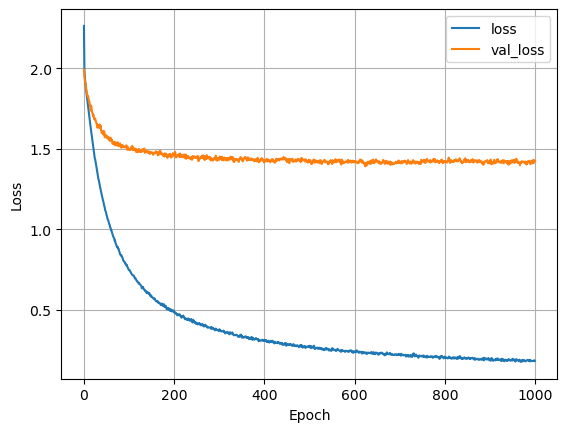

In [54]:
plot_loss(h)

In [56]:
predictions = model.predict(data_train)
mae, mse, r2 = get_score(labels_train, predictions)
print(f'''\nValues for validation set:\nMAE: {mae}\nMSE: {mse}\nRMSE: {mse**.5}\nR2:  {r2}''')

857/857 [==============================] - 1s 1ms/step

Values for validation set:
MAE: 0.088007918001174
MSE: 0.058634782125115234
RMSE: 0.24214619989815087
R2:  0.9903578001419397


In [55]:
predictions = model.predict(data_test)
mae, mse, r2 = get_score(labels_test, predictions)
print(f'''\nValues for validation set:\nMAE: {mae}\nMSE: {mse}\nRMSE: {mse**.5}\nR2:  {r2}''')

268/268 [==============================] - 0s 1ms/step

Values for validation set:
MAE: 1.4461617082163571
MSE: 5.511819239730513
RMSE: 2.3477263979711336
R2:  0.08610390972147103
